In [1]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [3]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [4]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [5]:
torch.manual_seed(0)
np.random.seed(0)

The lines of code you mentioned are used to set the seed for generating random numbers in PyTorch and NumPy respectively. Here's a detailed explanation:

`torch.manual_seed(0)`: This sets the seed for generating random numbers for PyTorch. It affects all random number generators in PyTorch, including those used for weight initialization in neural networks, data shuffling in data loaders, and any other random operations in PyTorch.

`np.random.seed(0)`: This sets the seed for generating random numbers for NumPy. It affects all random number generators in NumPy, including those used for data shuffling in train_test_split, random operations in NumPy, and any other libraries that use NumPy for random number generation.

Setting the seed for random number generation is important for reproducibility in scientific experiments. By setting the seed to a fixed number, you ensure that the random numbers generated in each run of your code are the same. This means that if you run your code multiple times with the same seed, you will get the same results, assuming that everything else in your code is deterministic.

However, please note that setting the seed will not make your code completely deterministic if you're using a GPU. Some operations in PyTorch are implemented with CUDA, which uses non-deterministic algorithms. If you need completely deterministic results, you should also set `torch.backends.cudnn.deterministic = True` and `torch.backends.cudnn.benchmark = False`. However, this can slow down your code.

In [6]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [7]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [8]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, None)

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, y=y)

/tmp/ipykernel_26817/1763704804.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)


In [9]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     0,     1,  ..., 13337, 13338, 13339],
        [    0, 13202,     1,  ..., 13337, 13338, 13339]])
2
26494


In [10]:
y.shape

torch.Size([13340])

In [11]:
y.size

<function Tensor.size>

In [12]:
x.size(1)

138

In [13]:
edge_index.shape

torch.Size([2, 26494])

In [14]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=40)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [15]:
print(y)

[2 2 2 ... 1 1 1]


In [16]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 64)
        self.conv2 = GATConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=-1)

In [17]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [18]:

model = GAT(num_features=x.size(1), num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'GAT_model_v2_64'
path = f'{path_to_saved_model_folder}/{model_name}.pth'



Fold 1 Test Accuracy: 0.6756756756756757
Fold 1 Test F1 Score: 0.6708494208494209
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        19
           1       0.71      0.56      0.63        18

    accuracy                           0.68        37
   macro avg       0.68      0.67      0.67        37
weighted avg       0.68      0.68      0.67        37



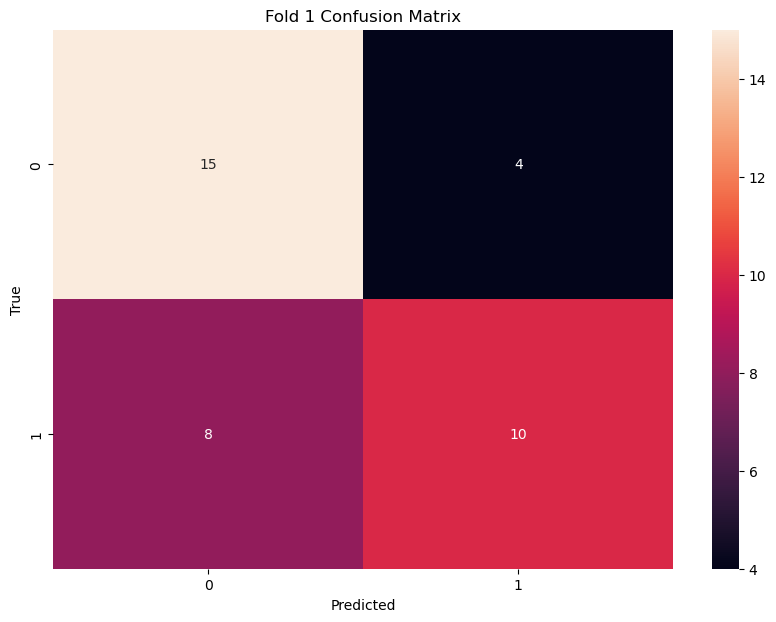

Fold 2 Test Accuracy: 0.8378378378378378
Fold 2 Test F1 Score: 0.8371224165341813
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.88      0.78      0.82        18

    accuracy                           0.84        37
   macro avg       0.84      0.84      0.84        37
weighted avg       0.84      0.84      0.84        37



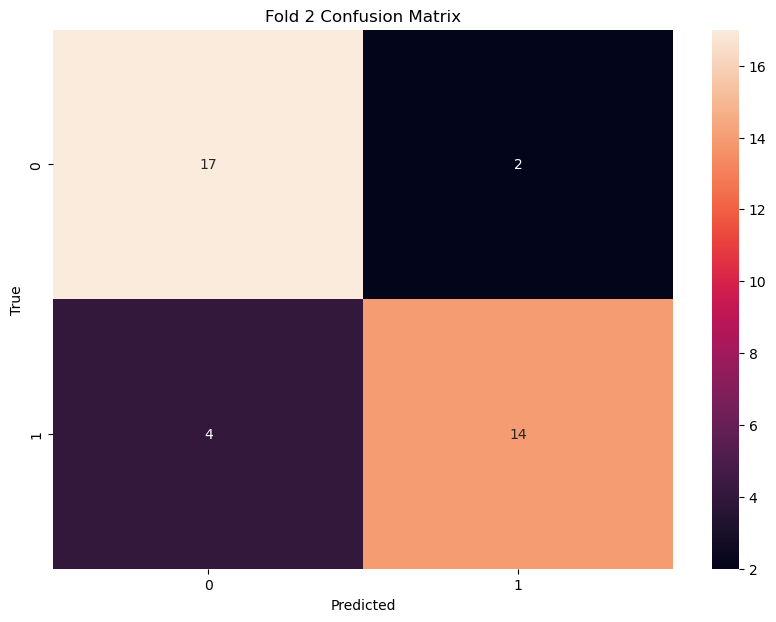

Fold 3 Test Accuracy: 0.7837837837837838
Fold 3 Test F1 Score: 0.7828298887122417
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.81      0.72      0.76        18

    accuracy                           0.78        37
   macro avg       0.79      0.78      0.78        37
weighted avg       0.79      0.78      0.78        37



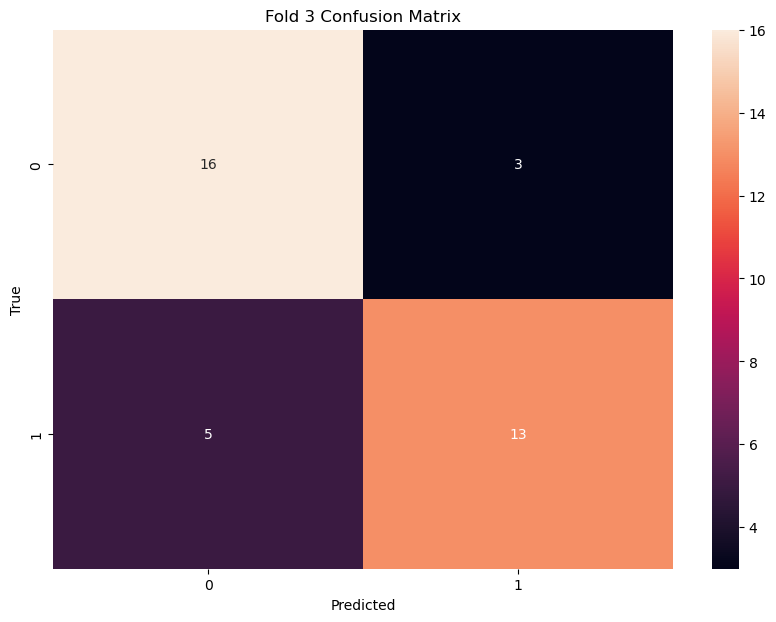

Fold 4 Test Accuracy: 0.7837837837837838
Fold 4 Test F1 Score: 0.7821750321750321
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.80      0.71      0.75        17

    accuracy                           0.78        37
   macro avg       0.79      0.78      0.78        37
weighted avg       0.79      0.78      0.78        37



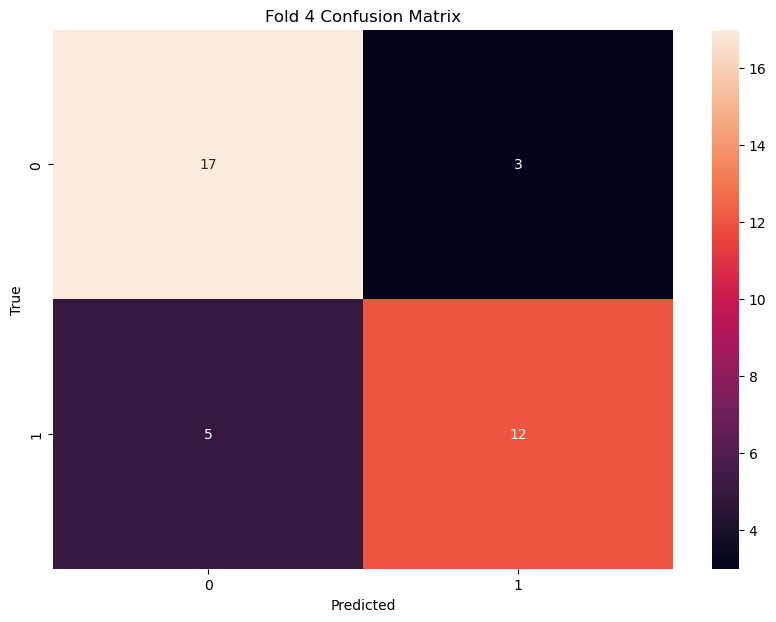

Fold 5 Test Accuracy: 0.7368421052631579
Fold 5 Test F1 Score: 0.7502451781627982
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        20
           1       1.00      0.56      0.71        18
           2       0.00      0.00      0.00         0

    accuracy                           0.74        38
   macro avg       0.56      0.49      0.50        38
weighted avg       0.84      0.74      0.75        38



/home/shoaib/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shoaib/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shoaib/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


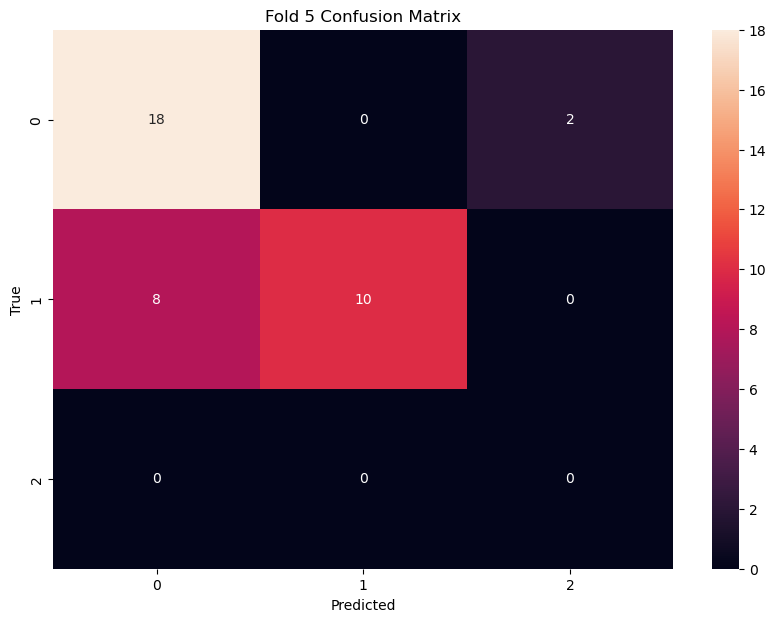

Average Test Accuracy: 0.7635846372688478
Average Test F1 Score: 0.7646443872867349


In [24]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store the accuracy and F1 score for each fold
accuracy_scores = []
f1_scores = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(cv.split(np.zeros(len(y)), y), start=1):
    # # Split the data into training and test sets
    data.train_mask = index_to_mask(torch.tensor(train_index), size=num_nodes)
    data.test_mask = index_to_mask(torch.tensor(test_index), size=num_nodes)

    # Train the model on the training set and save the best model
    # You should replace this with your actual training code
    # train()
    # torch.save(model.state_dict(), path)

    # Load the best model
    model.load_state_dict(torch.load(path))

    # predictions with the best model
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]

    # Create a mask for the fake and real news
    news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

    # Apply the mask to the labels and predictions
    labels_news = data.y[news_mask]
    preds_news = preds[news_mask]

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
    f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

    # Store the accuracy and F1 score
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f'Fold {i} Test Accuracy: {accuracy}')
    print(f'Fold {i} Test F1 Score: {f1}')

    report = classification_report(labels_news.cpu(), preds_news.cpu())
    print(f'Fold {i} Classification Report:')
    print(report)

    cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {i} Confusion Matrix')
    plt.show()

# Compute the average accuracy and F1 score
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Test Accuracy: {average_accuracy}')
print(f'Average Test F1 Score: {average_f1}')